In [323]:
REPORTS_FILE_PATH = 'reports/'

In [327]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# !conda install -c conda-forge lightgbm
from lightgbm import LGBMRegressor


# 4. Метирки качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image


# Python 2 and 3 compatibility
# pip install future
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# будем отображать графики прямо в jupyter'e
%pylab inline
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10,7


def evaluate_preds(true_values, pred_values, save=False, vals=500000):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, vals], [0, vals], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

Populating the interactive namespace from numpy and matplotlib


In [345]:
train = pd.read_csv('Kurs_project_task/train.csv')
test = pd.read_csv('Kurs_project_task/test.csv')

In [346]:
train['is_test'] = 0
test['is_test'] = 1

In [347]:
y_train = train['Price']
train.drop('Price', axis=1, inplace=True)

In [348]:
train.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [349]:
df = pd.concat([train, test])

In [350]:
df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,is_test
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,0
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,0
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,0
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,0
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,NaN,1,5,B,0
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,0
8,5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,0
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,B,B,6,1437,3,NaN,0,2,B,0


In [351]:
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
is_test            int64
dtype: object

In [352]:
df['Rooms'].value_counts()

2.0     5910
1.0     5474
3.0     3334
4.0      240
5.0       25
0.0       10
6.0        3
10.0       2
19.0       1
17.0       1
Name: Rooms, dtype: int64

In [353]:
df['KitchenSquare'].value_counts().unique()

array([3651, 1912, 1781, 1633, 1260, 1032,  906,  381,  340,  100,   71,
         60,   48,   33,   29,   17,   16,   13,    9,    8,    4,    3,
          2,    1])

In [354]:
df['HouseFloor'].value_counts().sort_index()

0.0       400
1.0       727
2.0        74
3.0       196
4.0       192
5.0      1581
6.0        93
7.0        87
8.0       213
9.0      2113
10.0      199
11.0       39
12.0     1600
13.0       40
14.0      969
15.0      172
16.0      811
17.0     3482
18.0      133
19.0      159
20.0      153
21.0       42
22.0      536
23.0       62
24.0      274
25.0      553
26.0        5
27.0       11
28.0        5
29.0        2
30.0       26
31.0        2
32.0        6
33.0        1
34.0        1
36.0        2
37.0        6
38.0        1
39.0        4
40.0       16
44.0        1
45.0        1
47.0        1
48.0        5
99.0        3
117.0       1
Name: HouseFloor, dtype: int64

In [355]:
df['HouseYear'].sort_values().unique()

array([    1908,     1909,     1910,     1911,     1912,     1914,
           1916,     1917,     1918,     1919,     1920,     1926,
           1927,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1943,     1947,
           1948,     1949,     1950,     1951,     1952,     1953,
           1954,     1955,     1956,     1957,     1958,     1959,
           1960,     1961,     1962,     1963,     1964,     1965,
           1966,     1967,     1968,     1969,     1970,     1971,
           1972,     1973,     1974,     1975,     1976,     1977,
           1978,     1979,     1980,     1981,     1982,     1983,
           1984,     1985,     1986,     1987,     1988,     1989,
           1990,     1991,     1992,     1993,     1994,     1995,
           1996,     1997,     1998,     1999,     2000,     2001,
           2002,     2003,     2004,     2005,     2006,     2

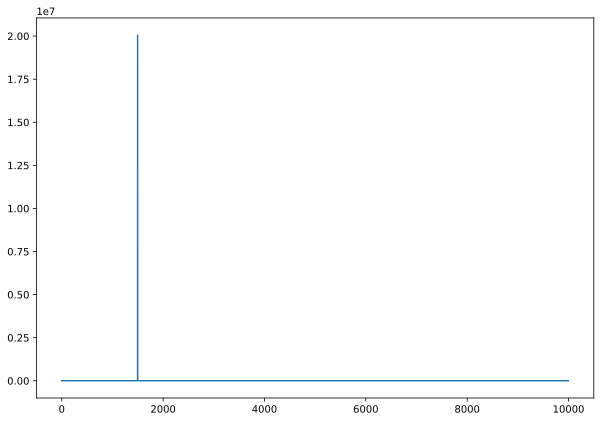

In [356]:
df['HouseYear'].plot()

In [357]:
df = pd.get_dummies(df)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,is_test,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,NaN,0,11,0,0,1,0,1,0,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,240.0,1,16,0,0,1,0,1,0,1
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,229.0,1,3,0,0,1,0,1,0,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,1084.0,0,5,0,0,1,0,1,0,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2078.0,2,4,0,0,1,0,1,0,1


In [358]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             15000 non-null  int64  
 1   DistrictId     15000 non-null  int64  
 2   Rooms          15000 non-null  float64
 3   Square         15000 non-null  float64
 4   LifeSquare     11846 non-null  float64
 5   KitchenSquare  15000 non-null  float64
 6   Floor          15000 non-null  int64  
 7   HouseFloor     15000 non-null  float64
 8   HouseYear      15000 non-null  int64  
 9   Ecology_1      15000 non-null  float64
 10  Social_1       15000 non-null  int64  
 11  Social_2       15000 non-null  int64  
 12  Social_3       15000 non-null  int64  
 13  Healthcare_1   7825 non-null   float64
 14  Helthcare_2    15000 non-null  int64  
 15  Shops_1        15000 non-null  int64  
 16  is_test        15000 non-null  int64  
 17  Ecology_2_A    15000 non-null  uint8  
 18  Ecology

In [359]:
df[['DistrictId', 'Rooms', 'Square']].sort_values(by=['DistrictId'])

,DistrictId,Rooms,Square
8969,0,2.0,65.832764
4374,0,2.0,77.331038
2853,0,2.0,48.662368
9840,0,3.0,70.322746
5577,0,2.0,43.337904
...,...,...,...
3194,209,1.0,34.678080
7650,209,1.0,33.533077
1043,210,2.0,54.953826
2666,211,2.0,46.501558


In [360]:
df['DistrictId'].unique().shape

(212,)

In [361]:
df.loc[df['HouseYear'] > 2020]
#df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,is_test,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,...,262.0,3,6,0,0,1,0,1,0,1
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,...,2857.0,5,8,0,0,1,0,1,0,1


In [128]:
df.loc[(df['DistrictId'] == 147) & (df['HouseYear'] <= 2020)]['HouseYear'].mean()

1968.6315789473683

In [129]:
df.loc[(df['DistrictId'] == 147) & (df['HouseYear'] <= 2020)]['HouseYear'].median()

1968.0

In [130]:
df.loc[(df['DistrictId'] == 147) & (df['HouseYear'] <= 2020)]['HouseYear'].shape

(19,)

In [362]:
df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = 2011
#df.loc[(df['DistrictId'] == 109) & (df['HouseYear'] == 20052011)]

In [133]:
df[df['HouseYear'] <= 2020].shape

(15000, 23)

In [168]:
df[df['HouseFloor'] < 1].shape

(400, 23)

In [171]:
df.loc[df['Floor'] == 2]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,is_test,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
23,6641,54,3.0,118.907612,NaN,0.0,2,1.0,1977,0.006076,...,645.0,6,6,0,0,1,0,1,0,1
34,8384,90,2.0,42.176782,28.085690,5.0,2,5.0,1965,0.265089,...,1937.0,3,2,0,0,1,0,1,0,1
73,9413,79,1.0,39.429666,18.519733,9.0,2,16.0,1981,0.169091,...,NaN,2,5,0,0,1,0,1,0,1
76,14020,34,1.0,47.909327,42.782385,1.0,2,1.0,2016,0.069753,...,NaN,1,11,0,0,1,0,1,0,1
84,7488,21,1.0,42.501226,22.915735,8.0,2,12.0,1979,0.194489,...,125.0,3,5,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4936,15613,32,1.0,35.998839,17.060621,5.0,2,5.0,1970,0.135650,...,350.0,3,11,1,0,1,0,1,0,1
4939,13952,57,2.0,47.985094,28.684640,5.0,2,5.0,1972,0.133215,...,1406.0,3,4,1,0,1,0,1,1,0
4944,6011,47,3.0,77.690373,50.464894,10.0,2,22.0,1983,0.000070,...,240.0,1,16,1,0,1,0,1,0,1
4972,16064,30,1.0,38.376234,37.003311,1.0,2,1.0,1977,0.000078,...,1046.0,3,23,1,0,1,0,1,0,1


In [170]:
df['HouseFloor'].value_counts().sort_index()

1.0     1127
2.0       74
3.0      196
4.0      192
5.0     1581
6.0       93
7.0       87
8.0      213
9.0     2116
10.0     199
11.0      39
12.0    1600
13.0      40
14.0     969
15.0     172
16.0     811
17.0    3483
18.0     133
19.0     159
20.0     153
21.0      42
22.0     536
23.0      62
24.0     274
25.0     553
26.0       5
27.0      11
28.0       5
29.0       2
30.0      26
31.0       2
32.0       6
33.0       1
34.0       1
36.0       2
37.0       6
38.0       1
39.0       4
40.0      16
44.0       1
45.0       1
47.0       1
48.0       5
Name: HouseFloor, dtype: int64

In [157]:
df['Floor'].value_counts().sort_index()

1      342
2      851
3     1278
4     1472
5     1371
6     1207
7     1106
8      970
9      902
10     820
11     681
12     650
13     589
14     541
15     438
16     427
17     360
18     277
19     189
20     110
21      94
22      80
23      58
24      71
25      53
26      32
27      13
28       4
31       2
32       4
33       2
34       1
37       1
38       1
42       1
46       1
78       1
Name: Floor, dtype: int64

In [164]:
df[df['Floor'] == 78]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,is_test,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B


In [363]:
df.loc[df['Floor'] == 78, 'Floor'] = 8

In [364]:
df[(df['Floor'] == 7) & (df['DistrictId'] == 17)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,is_test,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
270,15215,17,1.0,46.692974,5.941401,1.0,7,1.0,2015,0.000000,...,620.0,1,2,0,0,1,0,1,0,1
2984,9344,17,3.0,79.933044,50.623636,10.0,7,16.0,1979,0.000991,...,NaN,1,9,0,0,1,0,1,0,1
3071,8559,17,3.0,72.820902,48.310157,7.0,7,19.0,1970,0.000000,...,620.0,1,2,0,0,1,0,1,0,1
4258,11287,17,3.0,66.086745,43.429436,7.0,7,13.0,1979,0.000000,...,620.0,1,2,0,0,1,0,1,0,1
4779,11293,17,2.0,46.421150,30.595303,1.0,7,5.0,1962,0.000000,...,620.0,1,2,0,0,1,0,1,0,1
7846,8214,17,2.0,46.510867,30.664396,5.0,7,5.0,1965,0.000000,...,620.0,1,2,0,0,1,0,1,0,1
1297,13966,17,2.0,65.457987,37.499968,11.0,7,17.0,2010,0.093443,...,3300.0,2,4,1,0,1,0,1,0,1
1338,14108,17,1.0,32.233328,20.974668,7.0,7,9.0,1967,0.000000,...,620.0,1,2,1,0,1,0,1,0,1
2240,11934,17,2.0,44.294794,33.709973,5.0,7,8.0,1963,0.000000,...,46.0,1,1,1,0,1,0,1,0,1
3902,13446,17,3.0,86.717668,60.773024,8.0,7,8.0,1959,0.000000,...,46.0,1,1,1,0,1,0,1,0,1


In [166]:
df[(df['Floor'] == 8) & (df['DistrictId'] == 17)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,is_test,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
465,7067,17,3.0,85.887406,60.230135,9.0,8,8.0,1960,0.000000,...,46.0,1,1,0,0,1,0,1,0,1
930,12277,17,3.0,84.440032,58.902625,8.0,8,8.0,1958,0.000000,...,46.0,1,1,0,0,1,0,1,0,1
2534,10500,17,3.0,78.564131,45.599219,11.0,8,24.0,2010,0.093443,...,3300.0,2,4,0,0,1,0,1,0,1
6693,5120,17,3.0,78.578791,51.826876,10.0,8,16.0,1984,0.093443,...,3300.0,2,4,0,0,1,0,1,0,1
8622,12988,17,4.0,65.820574,51.872130,6.0,8,9.0,1968,0.000991,...,NaN,1,9,0,0,1,0,1,0,1
8676,1081,17,2.0,62.170585,36.273170,8.0,8,8.0,1960,0.000000,...,46.0,1,1,0,0,1,0,1,0,1
839,15960,17,3.0,67.730891,47.372408,8.0,8,8.0,1961,0.000000,...,46.0,1,1,1,0,1,0,1,0,1
1266,8159,17,3.0,80.256534,58.155110,10.0,8,10.0,1960,0.000000,...,46.0,1,1,1,0,1,0,1,0,1
2594,1506,17,3.0,126.525034,128.230078,12.0,8,15.0,2014,0.093443,...,3300.0,2,4,1,0,1,0,1,0,1
4698,15759,17,2.0,57.601870,37.744743,10.0,8,22.0,1989,0.000000,...,46.0,1,1,1,0,1,0,1,0,1


In [365]:
df[(df['HouseYear'] == 1977) & (df['DistrictId'] == 30)]['HouseFloor'].value_counts().sort_index()

0.0        5
1.0       22
2.0        3
3.0        5
4.0        3
5.0        3
8.0        1
9.0        1
12.0       4
14.0       1
15.0       1
16.0       5
17.0     105
19.0       4
20.0       2
21.0       3
22.0      13
23.0       1
24.0       3
25.0      10
117.0      1
Name: HouseFloor, dtype: int64

In [146]:
df[(df['HouseYear'] == 1977) & (df['DistrictId'] == 74)]['HouseFloor'].value_counts().sort_index()

0.0     19
1.0     17
2.0      1
3.0      2
4.0      1
6.0      2
7.0      1
8.0      1
9.0      1
10.0     1
12.0     3
14.0     1
17.0    33
18.0     2
19.0     1
20.0     2
21.0     2
22.0     4
24.0     2
25.0     2
99.0     1
Name: HouseFloor, dtype: int64

In [ ]:
df[df['HouseFloor'] == 99]

In [366]:
df.loc[df['HouseFloor'] == 117, 'HouseFloor'] = 17

In [71]:
train_2 = pd.read_csv('Kurs_project_task/train.csv')

In [72]:
# Если жилая площадь больше общей площади, то площадь = жилая площадь

train_2.loc[train_2['LifeSquare'] > train_2['Square'], 'Square'] = train_2['LifeSquare']

In [73]:
train_2[['LifeSquare', 'Square']][train_2['LifeSquare'] == train_2['Square']]

,LifeSquare,Square
28,43.967759,43.967759
44,106.340403,106.340403
52,65.224603,65.224603
123,89.803753,89.803753
153,53.491301,53.491301
...,...,...
9884,59.439082,59.439082
9889,53.134243,53.134243
9895,125.806981,125.806981
9902,44.267551,44.267551


In [31]:
df1 = df[[x for x in df.columns if 'Social' in x] + ['Id']]\
    .groupby('Id').sum()
df1.head()

,Social_1,Social_2,Social_3
Id,,,
0,25,4756,16
1,1,264,0
2,33,7425,1
3,37,5288,0
4,12,2270,23


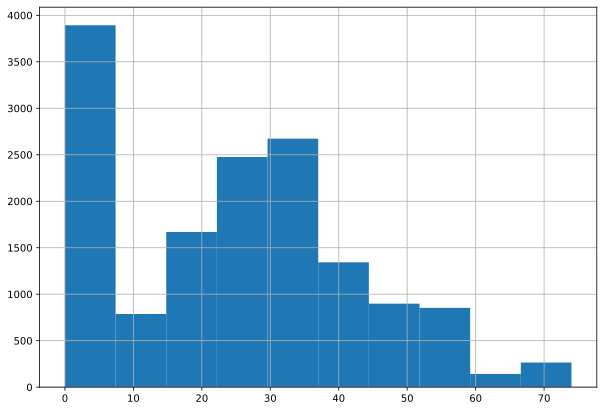

In [33]:
df['Social_1'].hist()

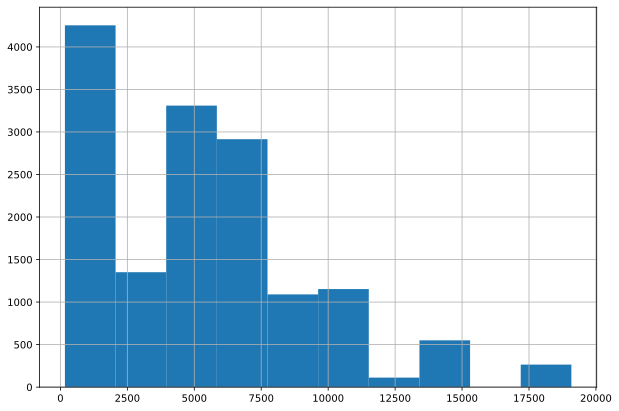

In [34]:
df['Social_2'].hist()

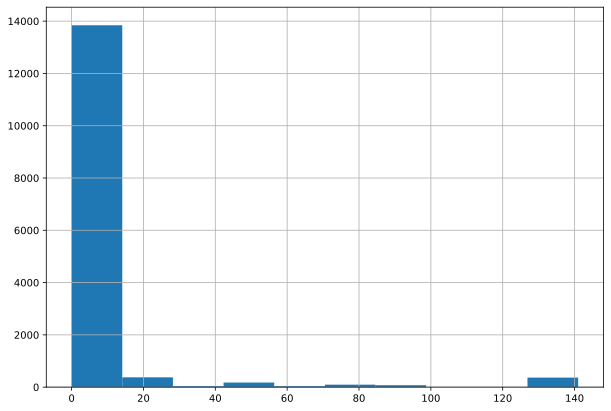

In [35]:
df['Social_3'].hist()

In [37]:
top_developers_df = df.groupby('DistrictId')[['Rooms']].sum()\
    .sort_values('Rooms', ascending=False).head(10)
top_developers_df.style.bar()

,Rooms
DistrictId,
27,2168.000000
1,1831.000000
23,1461.000000
6,1368.000000
9,871.000000
62,675.000000
30,611.000000
53,510.000000
58,465.000000


In [29]:
df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'is_test'],
      dtype='object')

In [18]:
df[df['HouseFloor'] == 0].shape

(400, 20)

In [19]:
df[df['HouseFloor'] != 0].shape

(14600, 20)

### Дубликаты после разделения тест и трейн

In [367]:
train = df[df.is_test==0].drop('is_test', axis=1)
test = df[df.is_test==1].drop('is_test', axis=1)

In [368]:
train.loc[train['Floor'] > train['HouseFloor'], 'Floor'] = train['HouseFloor']
test.loc[test['Floor'] > test['HouseFloor'], 'Floor'] = test['HouseFloor']

#### Жилая площадь

In [369]:
train.loc[train['LifeSquare'] > train['Square'], 'Square'] = train['LifeSquare']
test.loc[test['LifeSquare'] > test['Square'], 'Square'] = test['LifeSquare']

In [371]:
train.to_csv('second_blood_train.csv')
test.to_csv('second_blood_test.csv')

# Заполняю медианами и считаю RandomForestRegression

In [ ]:
train

# Сразу удаляю признак Healthcare_1 и работаю с LifeSquare

In [189]:
df_ls = train.drop('Healthcare_1', axis=1)

In [190]:
df_ls.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,14038,35,2.0,47.981561,29.442751,6.0,7.0,9.0,1969,0.089040,...,7976,5,0,11,0,1,0,1,0,1
1,15053,41,3.0,65.683640,40.049543,8.0,7.0,9.0,1978,0.000070,...,10309,1,1,16,0,1,0,1,0,1
2,4765,53,2.0,44.947953,29.197612,0.0,8.0,12.0,1968,0.049637,...,7759,0,1,3,0,1,0,1,0,1
3,5809,58,2.0,53.352981,52.731512,9.0,8.0,17.0,1977,0.437885,...,5735,3,0,5,0,1,0,1,0,1
4,10783,99,1.0,39.649192,23.776169,7.0,11.0,12.0,1976,0.012339,...,5776,1,2,4,0,1,0,1,0,1


In [191]:
df_ls[df_ls['LifeSquare'].isna()].shape

(2113, 21)

In [192]:
df_ls_train = df_ls[df_ls['LifeSquare'].notna()]

In [194]:
df_ls_train.shape

(7887, 21)

In [195]:
df_ls_test = df_ls[df_ls['LifeSquare'].isna()]

In [196]:
df_ls_test.drop('LifeSquare', axis=1, inplace=True)

# df_ls_train - для учебы с LifeSquare

In [229]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [246]:
X_ls = df_ls_train.drop('LifeSquare', axis=1)
y_ls = df_ls_train['LifeSquare']

In [292]:
X_ls = X_ls.drop('Id', axis=1)

In [293]:
X_ls.head()

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,35,2.0,47.981561,6.0,7.0,9.0,1969,0.089040,33,7976,5,0,11,0,1,0,1,0,1
1,41,3.0,65.683640,8.0,7.0,9.0,1978,0.000070,46,10309,1,1,16,0,1,0,1,0,1
2,53,2.0,44.947953,0.0,8.0,12.0,1968,0.049637,34,7759,0,1,3,0,1,0,1,0,1
3,58,2.0,53.352981,9.0,8.0,17.0,1977,0.437885,23,5735,3,0,5,0,1,0,1,0,1
4,99,1.0,39.649192,7.0,11.0,12.0,1976,0.012339,35,5776,1,2,4,0,1,0,1,0,1


In [310]:
y_ls2 = y_ls.astype(int)
y_ls2

0       29
1       40
2       29
3       52
4       23
        ..
9993    48
9995    30
9996    20
9998    33
9999    21
Name: LifeSquare, Length: 7887, dtype: int64

In [313]:
X_ls.to_csv('X_ls.csv')
y_ls2.to_csv('y_ls2.csv')

In [311]:
X_train_ls, X_test_ls, y_train_ls, y_test_ls = train_test_split(X_ls, 
                                                                y_ls2, 
                                                                test_size=0.2, 
                                                                random_state=100)

In [335]:
parameters = [{'n_estimators': np.arange(80, 200, 50),
               'max_features': np.arange(3, 50, 10),
               'max_depth': np.arange(4, 20, 8),
               'min_samples_leaf':np.arange(10, 11),
               }]

rfc_ls = GridSearchCV(
    estimator=RandomForestRegressor(random_state=100), 
    param_grid=parameters,
    cv=5)
rfc_ls.fit(X_train_ls, y_train_ls)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=100,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_job

In [336]:
rfc_ls_real = rfc_ls.best_estimator_
rfc_ls_real.fit(X_train_ls, y_train_ls)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features=13, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=80, n_jobs=None, oob_score=False,
                      random_state=100, verbose=0, warm_start=False)

In [337]:
y_pred_train_ls = rfc_ls_real.predict(X_train_ls)
y_pred_test_ls = rfc_ls_real.predict(X_test_ls)

R2:	0.729
RMSE:	9.679
MSE:	93.683


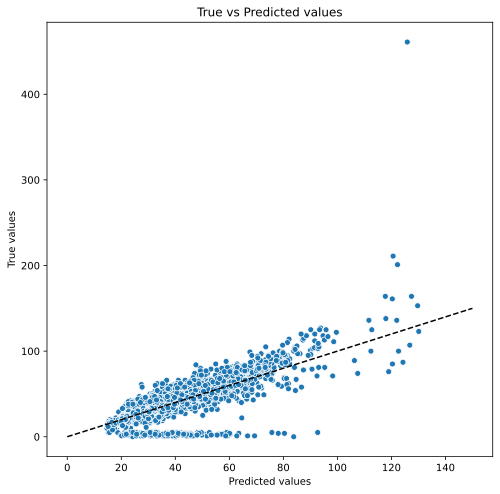

In [338]:
evaluate_preds(y_train_ls, y_pred_train_ls, save=True, vals=150)

R2:	0.729
RMSE:	9.679
MSE:	93.683


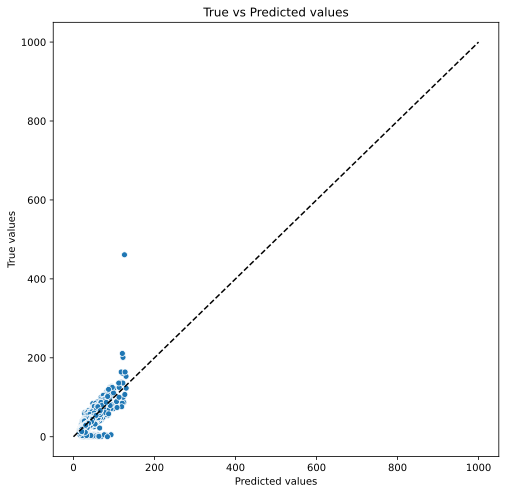

In [339]:
evaluate_preds(y_train_ls, y_pred_train_ls, save=False, vals=1000)

In [297]:
r2(y_test_ls, y_pred_test_ls)

0.05661364441040784

In [298]:
y_pred_test_ls

array([34.65663923, 34.73950678, 39.5635501 , ..., 56.53154485,
       21.70873032, 25.15605679])

In [299]:
y_test_ls.to_numpy()

array([36.59382419, 35.98630253, 42.79085808, ..., 62.89829298,
       23.92697958, 25.54285103])

In [300]:
y_error = y_test_ls - y_pred_test_ls

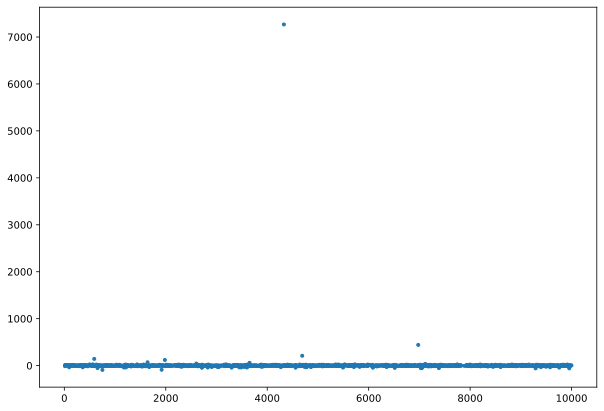

In [301]:
#y_error.scatter()
y_error.plot(style='.')

In [302]:
y_error.sort_values()

751      -91.049008
1918     -88.393715
9954     -58.551747
9291     -58.348333
7028     -53.778605
           ...     
1982     120.631847
590      143.197286
4690     210.210677
6977     441.388198
4328    7267.075250
Name: LifeSquare, Length: 1578, dtype: float64

In [303]:
X_train_ls.iloc[4328]

DistrictId          6.000000
Rooms               1.000000
Square             42.466813
KitchenSquare       1.000000
Floor              14.000000
HouseFloor         17.000000
HouseYear        2014.000000
Ecology_1           0.243205
Social_1            5.000000
Social_2         1564.000000
Social_3            0.000000
Helthcare_2         0.000000
Shops_1             0.000000
Ecology_2_A         0.000000
Ecology_2_B         1.000000
Ecology_3_A         0.000000
Ecology_3_B         1.000000
Shops_2_A           0.000000
Shops_2_B           1.000000
Name: 4447, dtype: float64

In [304]:
X_train_ls.iloc[4327]

DistrictId          77.000000
Rooms                1.000000
Square              45.779255
KitchenSquare        8.000000
Floor                7.000000
HouseFloor          12.000000
HouseYear         1983.000000
Ecology_1            0.000070
Social_1            46.000000
Social_2         10309.000000
Social_3             1.000000
Helthcare_2          1.000000
Shops_1             16.000000
Ecology_2_A          0.000000
Ecology_2_B          1.000000
Ecology_3_A          0.000000
Ecology_3_B          1.000000
Shops_2_A            0.000000
Shops_2_B            1.000000
Name: 4914, dtype: float64